In [162]:
import numpy as np
import pandas as pd

import bct
import glob
import os
import seaborn as sns
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter  # useful for `logit` scale

from pathlib import Path
np.set_printoptions(suppress=True)


%matplotlib inline

# Styles
sns.set_context('poster')
sns.set_style('darkgrid')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 15),
         'axes.labelsize': 'x-small',
         'axes.titlesize':'x-small',
         'xtick.labelsize':'x-small',
         'ytick.labelsize':'x-small'}

plt.rcParams.update(params)

In [3]:
def module_nodes(modules, module):
    nodes = []
    
    for (key, value) in modules.items():
        if value == module:
            nodes.append(key)
            
    return nodes

In [184]:
def relative_degree(grid, nodes, node):
    all_nodes = nodes
    if not np.isin(node, nodes):
        all_nodes.append(node)
    
    return (grid.subgraph(all_nodes).degree(node))

In [185]:
def global_degree(node, grid):
    return(grid.degree(node))

In [223]:
def participation_coefficient(grid, modules, node):
    acum = 0
    number_of_modules = len(set(list(modules.values())))

    global_degree_value = global_degree(node, grid)        
    
    if global_degree_value > 0:
        for module in range(1,number_of_modules):
            relative_degree_value = relative_degree(grid, module_nodes(modules, module), node)                
            acum += pow(relative_degree_value / global_degree_value, 2)
            
    return (1-acum)        

In [187]:
def intra_modular_degree_zscore(grid, modules, node):
    module = modules[node]    
    nodes = module_nodes(modules, module)
    relative_degrees = {}
    
    for  n in nodes:
        relative_degrees[n] = relative_degree(grid, nodes, n)
    
    im_degree = relative_degrees[node]
    degrees_values = list(relative_degrees.values())
    im_mean = np.mean(degrees_values)        
    im_std_deviation = np.std(degrees_values)
    
    if im_std_deviation > 0:
        return ((im_degree - im_mean) / im_std_deviation)
    else:
        return (0)
    

In [173]:
def node_clasfication(P_c, Z_c, P_i, Z_i):
    if (P_i > P_c and Z_i > Z_c):
        return("hub")
    if (P_i <= P_c and Z_i > Z_c):
        return("provincial_hub")
    if (P_i <= P_c and Z_i <= Z_c):
        return("provincial_node")
    if (P_i > P_c and Z_i <= Z_c):
        return("connector_node")
    

In [9]:
def node_roles(G, P_c, Z_c):
    result = {}
    roles = []
    modules = community_louvain.best_partition(G)

    for node in G.nodes():
        Z_i = intra_modular_degree_zscore(G, modules, node)
        P_i = participation_coefficient(G, modules, node)
        role = node_clasfication(P_c, Z_c, P_i, Z_i)        
        result[node] = list([Z_i, P_i, role])
        roles.append(role)
    
    return([result, roles])

In [10]:
def grid_roles(G, P_c, Z_c):
    roles_stats, roles = node_roles(G, P_c, Z_c)
    unique_roles, counts = np.unique(roles, return_counts=True)
    
    result = {"hub" : 0,
              "provincial_hub": 0,
              "provincial_node": 0,
              "connector_node": 0}
    
    for i in range(0, len(unique_roles)):
        result[unique_roles[i]] = counts[i]
        
    return (result)
    

In [11]:
def subjectmatrix_to_graphs(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densidad de aristas correspondiente
    """

    correlation_matrix = pd.read_csv(
        filename,
        header=None
    )
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(
        correlation_matrix.values[tril_idx].flatten(),
        reverse=True
    )

    #Gs = []
    Gs = {}
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs[d] = nx.from_pandas_adjacency(correlation_matrix>=threshold)

    return Gs

In [12]:
def extract_graphs(tipo_red, densities):

    path = r'../resources/DataSujetos' # use your path
    all_files = glob.glob(path + "/{}_suj*.csv".format(tipo_red))


    graphs = {}
    for filename in all_files:
        Gs = subjectmatrix_to_graphs(filename, densities)
        name = Path(filename).stem
        graphs[name] = Gs

    return graphs

In [78]:
def roles_per_state(Gs):
    roles = []
    for (sub, gs) in Gs.items():
        for (density, g) in gs.items():
            grid_roles_values = grid_roles(g, 0.05, 1)
            roles.append([density, grid_roles_values["hub"]
                            , grid_roles_values["provincial_hub"]
                            , grid_roles_values["provincial_node"]
                            , grid_roles_values["connector_node"]])
    return (np.array(roles))

In [237]:
def agregate_per_density(roles):
    result = []
        
    for d in densities:
        density_filter = np.asarray([d])
        by_density = roles[np.in1d(roles[:, 0], density_filter)]
        result.append(np.mean(by_density, axis=0))
        
    return (np.array(result))

            

In [238]:
densities = np.linspace(0.025,0.15,num=5)

G_N1 = extract_graphs("N1", densities)
G_N2 = extract_graphs("N2", densities)
G_N3 = extract_graphs("N3", densities)
G_W = extract_graphs("W", densities)

In [239]:
roles_N1 = roles_per_state(G_N1)

In [245]:
roles_N2 = roles_per_state(G_N2)

In [246]:
roles_N3 = roles_per_state(G_N3)

In [241]:
roles_W = roles_per_state(G_W)

In [240]:
roles_mean_N1 = agregate_per_density(roles_N1)

In [247]:
roles_mean_N2 = agregate_per_density(roles_N2)

In [248]:
roles_mean_N3 = agregate_per_density(roles_N3)

In [242]:
roles_mean_W = agregate_per_density(roles_W)

In [243]:
roles_mean_N1

array([[ 0.025     ,  5.94444444,  7.11111111, 50.94444444, 52.        ],
       [ 0.05625   , 10.16666667,  5.16666667, 46.11111111, 54.55555556],
       [ 0.0875    , 13.5       ,  4.27777778, 36.27777778, 61.94444444],
       [ 0.11875   , 12.77777778,  3.66666667, 32.38888889, 67.16666667],
       [ 0.15      , 12.61111111,  3.05555556, 26.94444444, 73.38888889]])

In [218]:
def plot_Nx_vs_W_roles(Nx_roles, W_roles, title, label_nx):
    fig, axs = plt.subplots(4, sharex=True)
    fig.suptitle(title)
    axs[0].plot(densities, Nx_roles[:, 1], label=label_nx)
    axs[0].plot(densities, W_roles[:, 1], label='W')
    axs[0].set(ylabel='hubs')
    axs[1].plot(densities, Nx_roles[:, 2])
    axs[1].plot(densities, W_roles[:, 2])
    axs[1].set(ylabel='provincial hubs')
    axs[2].plot(densities, Nx_roles[:, 3])
    axs[2].plot(densities, W_roles[:, 3])
    axs[2].set(ylabel='provincial nodes')
    axs[3].plot(densities, Nx_roles[:, 4])
    axs[3].plot(densities, W_roles[:, 4])
    axs[3].set(ylabel='connector nodes')

    for ax in axs.flat:
        ax.set(xlabel='density')

    for ax in axs.flat:
        ax.label_outer()
        
    
    legend = axs[0].legend(loc='best', shadow=True, fontsize='x-small')

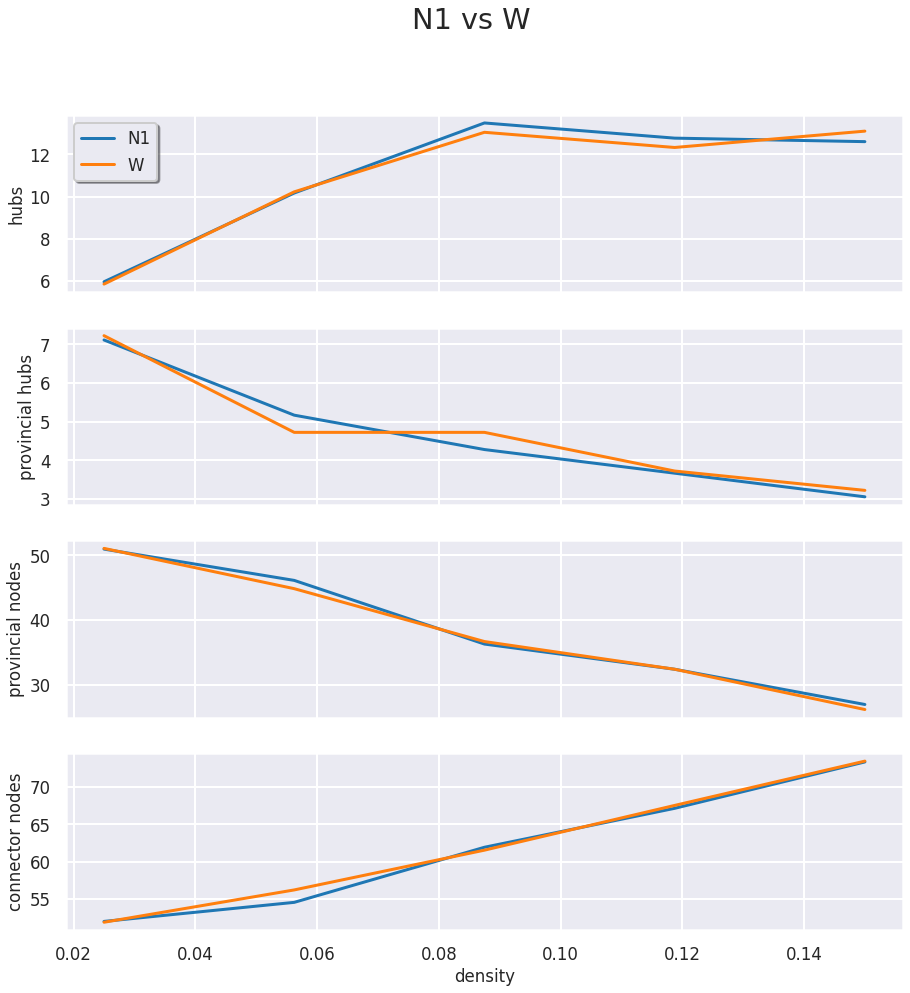

In [244]:
plot_Nx_vs_W_roles(roles_mean_N1, roles_mean_W, 'N1 vs W', 'N1')

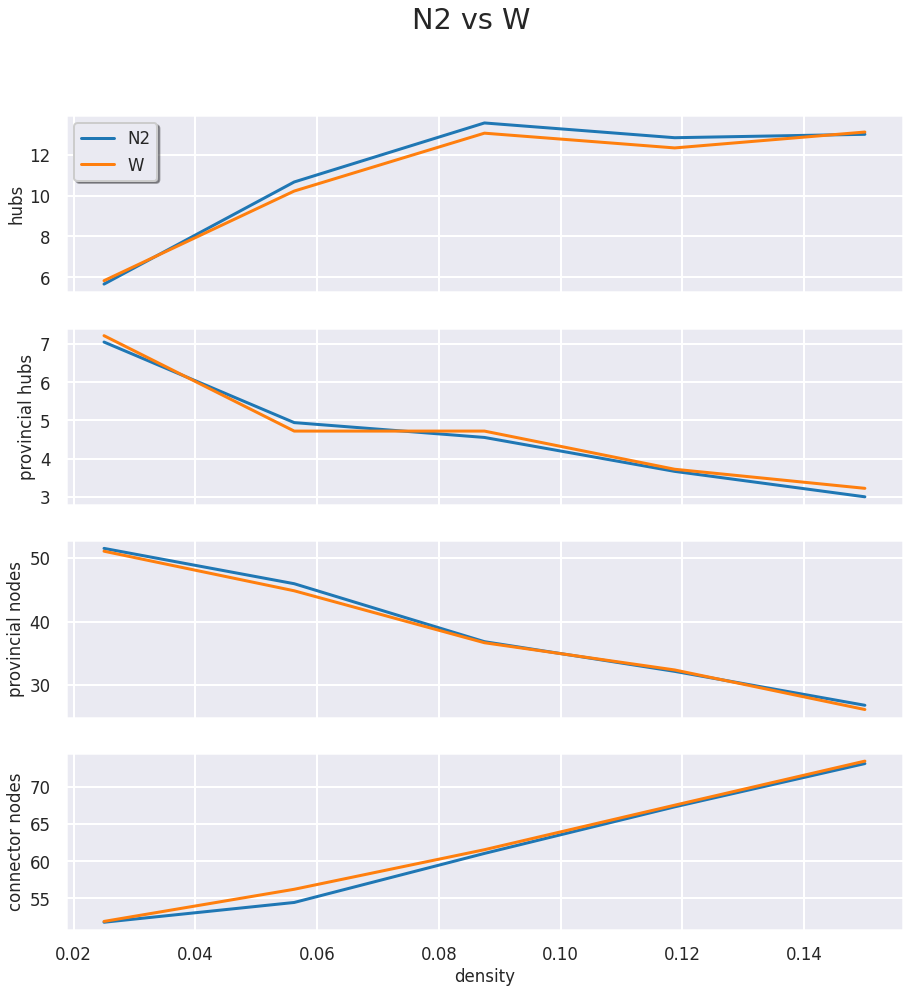

In [249]:
plot_Nx_vs_W_roles(roles_mean_N2, roles_mean_W, 'N2 vs W','N2')

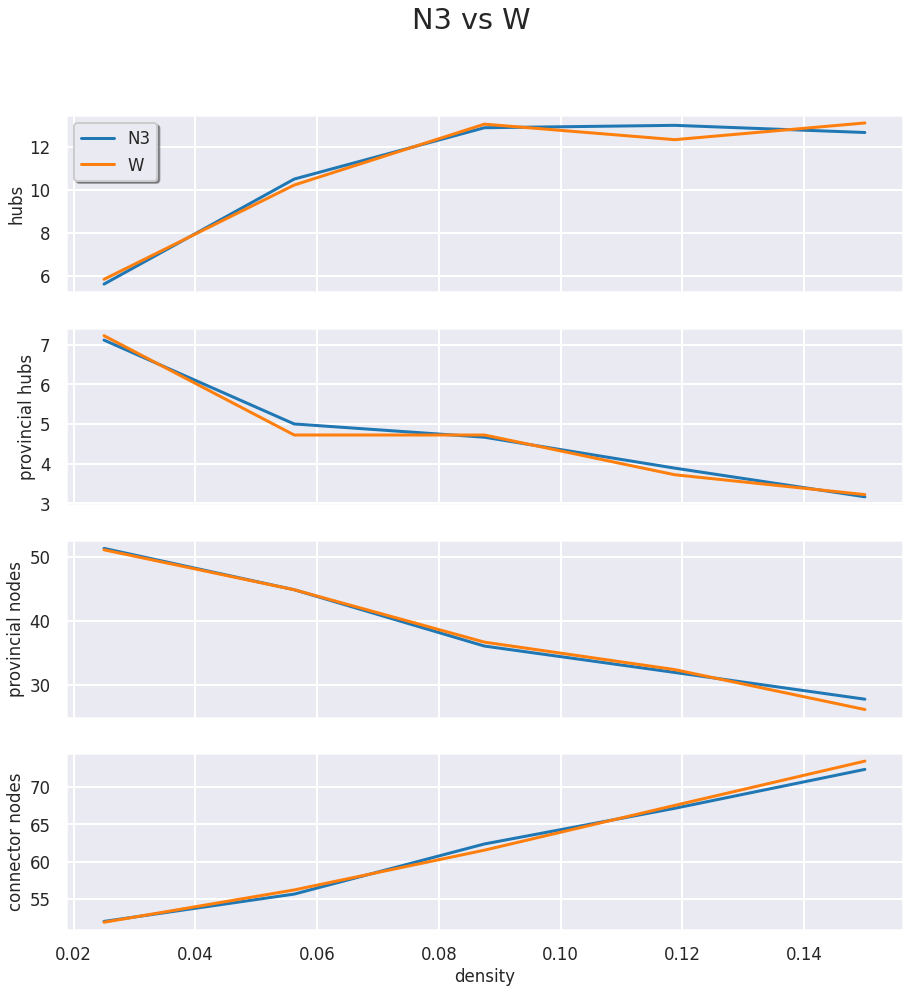

In [250]:
plot_Nx_vs_W_roles(roles_mean_N3, roles_mean_W, 'N3 vs W','N3')